# Lab 09: RNNs

Some references for the materials used for this lab:
- https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks
- https://www.simplilearn.com/tutorials/deep-learning-tutorial/rnn

Today we'll do some preliminary investigation of simple RNNs similar to the form of Figure 10.3 in Goodfellow et al. (the Elman network).


In [ ]:
name = 'Todsavad Tangtortan'
id   = 'st123012'

# Task 1. 
Change the structure to be identical to Goodfellow's Figure 10.3 (no input-to-hidden connection) with tanh activation functions
   and see if you get different results.

In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('Number of categories: ', n_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski
Number of categories:  18


In [7]:
# Check that it worked

for c in all_categories[:2]:
    print(c)
    print(category_lines[c]) 
print('Italian')
print(category_lines['Italian'][:5])

Arabic
['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari', 'Maalouf', 'Gerges', 'Naifeh', 'Guirguis', 'Baba', 'Sabbagh', 'Attia', 'Tahan', 'Haddad', 'Aswad', 'Najjar', 'Dagher', 'Maloof', 'Isa', 'Asghar', 'Nader', 'Gaber', 'Abboud', 'Maalouf', 'Zogby', 'Srour', 'Bahar', 'Mustafa', 'Hanania', 'Daher', 'Tuma', 'Nahas', 'Saliba', 'Shamoon', 'Handal', 'Baba', 'Amari', 'Bahar', 'Atiyeh', 'Said', 'Khouri', 'Tahan', 'Baba', 'Mustafa', 'Guirguis', 'Sleiman', 'Seif', 'Dagher', 'Bahar', 'Gaber', 'Harb', 'Seif', 'Asker', 'Nader', 'Antar', 'Awad', 'Srour', 'Shadid', 'Hajjar', 'Hanania', 'Kalb', 'Shadid', 'Bazzi', 'Mustafa', 'Masih', 'Ghanem', 'Haddad', 'Isa', 'Antoun', 'Sarraf', 'Sleiman', 'Dagher', 'Najjar', 'Malouf', 'Nahas', 'Naser', 'Saliba', 'Shamon', 'Malouf', 'Kalb', 'Daher', 'Maalouf', 'Wasem', 'Kanaan', 'Naifeh', 'Boutros', 'Moghadam', 'Masih', 'Sleiman', 'Aswad', 'Cham', 'Assaf', 'Quraishi', 'Shalhoub', 'Sabbag', 'Mifsud', 'Gaber', 'Shammas', 'Tannous', 'Sleiman', 'Bazzi', 'Quraishi', 'Raha

## One-hot representation of characters

Next, let's see how to convert each letter in a word to a sequence of one-hot representations, for example mapping the character `b` tot he vector $[0 1 0 0 0 ...]$.
The tensor size will be `linelength` $\times$ 1 $\times$ `nletters`. The first dimension is the number of characters in a given word/line of a data file,
the second dimension is the index into the batch (we have a batch size of 1 here), and the third dimension indexes the different characters in the vocabulary.

There are many ways to do it. Scikit-learn has functionality to perform one-hot encoding for an arbitrary dictionary:

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## The RNN

Next, let's implement the RNN structure itself:

<img src="img/rnns_code2.png" title="RNNs" style="width: 400px;" />

<img src="img/Figure10_3.png" title="RNNs" style="width: 400px;" />

### RNNlman

### RNNGoodFellow

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Sequential(
            nn.Linear(input_size + hidden_size, hidden_size),
            nn.Tanh()
            )
        self.i2o = nn.Linear(hidden_size, output_size) #add tanh
        self.softmax = nn.LogSoftmax(dim=1)  #logsoftmax thats why -2.XXX to avoid tiny bit of computation

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(hidden) #take from hidden
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [10]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9334, -2.9737, -2.9333, -2.8142, -2.9702, -2.8929, -2.8506, -3.0158,
         -2.9247, -2.8098, -2.7985, -2.8564, -2.9115, -2.8476, -2.9280, -2.7851,
         -2.8723, -2.9465]], grad_fn=<LogSoftmaxBackward0>)

In [12]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = rnn(input[i], next_hidden)
    print(output)

tensor([[-2.9334, -2.9737, -2.9333, -2.8142, -2.9702, -2.8929, -2.8506, -3.0158,
         -2.9247, -2.8098, -2.7985, -2.8564, -2.9115, -2.8476, -2.9280, -2.7851,
         -2.8723, -2.9465]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9551, -2.9759, -2.9027, -2.8494, -2.9317, -2.8882, -2.8777, -2.9839,
         -2.9443, -2.8444, -2.8229, -2.8255, -2.9672, -2.8300, -2.8579, -2.7978,
         -2.8439, -2.9599]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9986, -3.0087, -2.9168, -2.8014, -2.9429, -2.8627, -2.7926, -3.0548,
         -2.8916, -2.8433, -2.8142, -2.8464, -2.9222, -2.8128, -2.9300, -2.7894,
         -2.9092, -2.9414]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9113, -2.9481, -2.8807, -2.8388, -2.9475, -2.8920, -2.8705, -3.0070,
         -2.9282, -2.8480, -2.8188, -2.8148, -2.9828, -2.8147, -2.9343, -2.7894,
         -2.8489, -2.9884]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9338, -2.9932, -2.8765, -2.8184, -2.9674, -2.8944, -2.8151, -3.0160,
         -2.9306, -2.8750, -2.8

### Training

To get started with training, we need some helper functions.
This one converts an output vector to a category:

In [15]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# print(categoryFromOutput(output))

In [16]:
import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

# for i in range(10):
#     category, line, category_tensor, line_tensor = randomTrainingExample()
#     print('category =', category, '/ line =', line)

In [17]:
criterion = nn.NLLLoss() 

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate * p.grad.data)

    return output, loss.item()  

In [18]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 2.5215 Dubanowski / Japanese ✗ (Polish)
10000 10% (0m 15s) 2.7630 Schubert / Dutch ✗ (Czech)
15000 15% (0m 22s) 2.5172 Noel / German ✗ (French)
20000 20% (0m 30s) 1.4528 Pellegrino / Portuguese ✗ (Italian)
25000 25% (0m 38s) 1.6819 Marmo / Portuguese ✗ (Italian)
30000 30% (0m 47s) 2.7306 Oliver / Czech ✗ (French)
35000 35% (0m 55s) 3.5994 Meeuwis / Greek ✗ (Dutch)
40000 40% (1m 2s) 0.1821 Spyridis / Greek ✓
45000 45% (1m 10s) 1.2285 Souza / Arabic ✗ (Portuguese)
50000 50% (1m 17s) 0.5636 Christie / Scottish ✓
55000 55% (1m 24s) 0.5454 Trieu / Vietnamese ✓
60000 60% (1m 31s) 0.2179 Yu / Korean ✓
65000 65% (1m 38s) 1.1173 Sobol / Polish ✓
70000 70% (1m 46s) 1.9797 Onischuk / Arabic ✗ (Russian)
75000 75% (1m 53s) 1.7990 Mateu / French ✗ (Spanish)
80000 80% (2m 1s) 0.1213 Vuu / Vietnamese ✓
85000 85% (2m 7s) 0.0173 Shimaoka / Japanese ✓
90000 90% (2m 14s) 0.1498 Campbell / Scottish ✓
95000 95% (2m 24s) 4.0601 Dana / Italian ✗ (Czech)
100000 100% (2m 32s) 0.2682 Sniders / Du

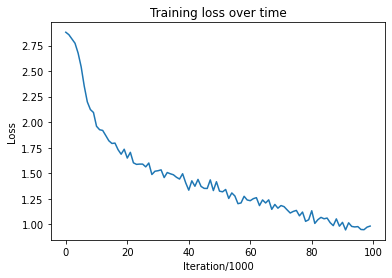

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.title('Training loss over time')
plt.xlabel('Iteration/1000')
plt.ylabel('Loss')
plt.plot(all_losses)

### Evaluation

Great, we have a trained model. Let's get a confusion matrix:

C:\Users\Guntsv\AppData\Local\Temp\ipykernel_21628\3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\Guntsv\AppData\Local\Temp\ipykernel_21628\3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


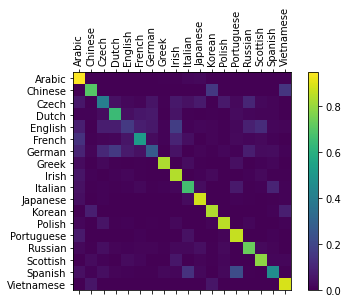

In [20]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

Take a look at the most likely confusions and see if they make sense.

### Prediction on user input

Finally, try classifying novel inputs:

In [21]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Todsavad')


> Dovesky
(-0.63) Russian
(-1.01) Czech
(-3.09) Polish

> Jackson
(-0.20) Scottish
(-2.45) English
(-2.98) Czech

> Satoshi
(-0.12) Japanese
(-3.28) Arabic
(-3.48) Polish

> Todsavad
(-0.93) French
(-1.34) Dutch
(-2.20) Russian


# Task 2. 
Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

In [22]:
# Set device to GPU or CPU
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [23]:
names = []
targets = []

for k,v in category_lines.items():
    for name in v:
        names.append(name)
        targets.append(k)

print(len(names))
print(len(targets))

20074
20074


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(names, targets, test_size = 0.2, random_state = 123, stratify = targets)

In [30]:
print("The number of train data : ", len(X_train))
print("The number of test data  : ", len(X_test))

The number of train data :  16059
The number of test data  :  4015


In [43]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#function to create vec representation of the language
def langugaeToTensor(lang):
    return torch.tensor([all_categories.index(lang)], dtype = torch.long)

print(lineToTensor('Gun').size())

print(langugaeToTensor("Italian"))
print(langugaeToTensor("Italian").size())

torch.Size([3, 1, 57])
tensor([9])
torch.Size([1])


### RNN model 

In [47]:
#create simple rnn network 
import torch.nn as nn
class RNN_model(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_model, self).__init__()
        self.hidden_size = hidden_size 

        # Applies a multi-layer Elman RNN with \tanhtanh or \text{ReLU}ReLU non-linearity to an input sequence.
        self.rnn_cell = nn.RNN(input_size, hidden_size)

        self.i20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output      = self.i20(hidden.view(-1, self.hidden_size))
        output      = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size)

In [48]:
#function to run interference
def infer(model, name, device = "cpu"):
    name_tensor = lineToTensor(name).to(device)
    #get the output
    output, hidden = model(name_tensor)
    if type(hidden) is tuple: #for LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [49]:
#create hidden layers
n_hidden = 128 #hidden layers count
#number of languages
n_languages = len(category_lines.keys())
print("Total number of languages present: ", n_languages)
#initialize the network
model = RNN_model(n_letters, n_hidden, n_languages)
model = model.to(device)

Total number of languages present:  18


In [51]:
input = lineToTensor('G')

# put stuff on GPU
input = input.to(device)
hidden = torch.zeros((1,1, n_hidden)).to(device)

output, next_hidden = model(input, hidden)
output

tensor([[-2.9011, -2.9324, -2.9716, -2.7964, -2.8353, -2.8660, -2.9361, -2.8852,
         -2.8852, -2.9123, -2.8523, -3.0221, -2.8715, -2.8568, -2.7716, -2.8899,
         -2.9558, -2.9164]], grad_fn=<LogSoftmaxBackward0>)

In [53]:
input = lineToTensor('Gun')
hidden = torch.zeros((1,1, n_hidden))

# put stuff on GPU
input = input.to(device)
hidden = hidden.to(device)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = model(input[i].reshape(1,1,-1), next_hidden)
    print(output)

tensor([[-2.9011, -2.9324, -2.9716, -2.7964, -2.8353, -2.8660, -2.9361, -2.8852,
         -2.8852, -2.9123, -2.8523, -3.0221, -2.8715, -2.8568, -2.7716, -2.8899,
         -2.9558, -2.9164]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9282, -2.9227, -2.9692, -2.8450, -2.8584, -2.8262, -2.8676, -2.8613,
         -2.8829, -2.9214, -2.8687, -2.8862, -2.9240, -2.9008, -2.7623, -2.9447,
         -2.9735, -2.9071]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9581, -2.9398, -2.9089, -2.8102, -2.8193, -2.8553, -2.9010, -2.8957,
         -2.8653, -2.9184, -2.8371, -2.9643, -2.9203, -2.8926, -2.7802, -2.8942,
         -2.9722, -2.9192]], grad_fn=<LogSoftmaxBackward0>)


Visualization

In [54]:
count = {}
for l in all_categories: 
    count[l] = 0
for k,v in category_lines.items():
    count[k] += len(v)

print(count)

{'Arabic': 2000, 'Chinese': 268, 'Czech': 519, 'Dutch': 297, 'English': 3668, 'French': 277, 'German': 724, 'Greek': 203, 'Irish': 232, 'Italian': 709, 'Japanese': 991, 'Korean': 94, 'Polish': 139, 'Portuguese': 74, 'Russian': 9408, 'Scottish': 100, 'Spanish': 298, 'Vietnamese': 73}


c:\Python3.10.4\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


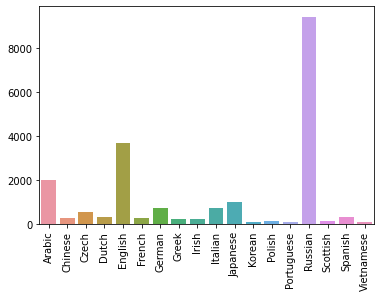

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show() #Biassssssssssssssssssssssssssss

Dataloader & Evaluate Model

Check whether it works before training!

In [56]:
import numpy as np
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    loader = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        loader.append((name, lang, lineToTensor(name), langugaeToTensor(lang)))
    
    return loader

In [57]:
dataloader(2, X_train, y_train)

[('Tokaev',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [58]:
def eval(net, n_points, topk, X_, y_, device = "cpu"):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:

        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

In [59]:
#test the evaluation function
eval(model, 1000, 1, X_test, y_test)

0.404

Batching pytorch

In [72]:
#create a batched name rep
def batched_lineToTensor(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

def batched_languageToTensor(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

In [73]:
#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_lineToTensor(names, max_length).to(device)
    langs_rep = batched_languageToTensor(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('LanguageToTensor', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [74]:
out_ = batched_lineToTensor(['Gun', 'Tonson'], 6)
print_char(out_)

G
T
u
o
n
n
<pad>
s
<pad>
o
<pad>
n


In [75]:
batched_dataloader(2, X_train, y_train, True)

torch.Size([9, 2, 57]) torch.Size([15, 57])
--
['Leiferkus', 'Wahner']
L
W
e
a
i
h
f
n
e
e
r
r
k
<pad>
u
<pad>
s
<pad>
--
L
W
e
a
i
h
f
n
e
e
r
r
k
u
s
LanguageToTensor tensor([14,  6])
Batch sizes tensor([2, 2, 2, 2, 2, 2, 1, 1, 1])


(PackedSequence(data=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         

### Training

In [76]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [77]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [83]:
import torch.optim as optim

net = RNN_model(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [84]:
%%time 
#time for normal training
train(model, optimizer, criterion, 256)

CPU times: total: 281 ms
Wall time: 563 ms


tensor(2.8340, grad_fn=<DivBackward0>)

In [87]:
from IPython.display import clear_output

def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))

Iteration 2499 Loss 0.5031614899635315


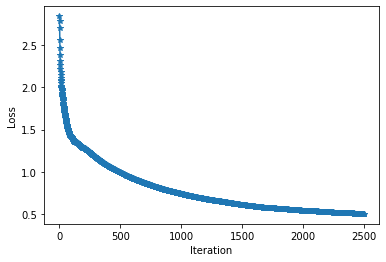

In [88]:
%%time

#training RNN using batch technique
model = RNN_model(n_letters, n_hidden, n_languages)
train_setup(model, lr=0.15, n_batches=3200, batch_size = 512, display_freq=500) # CPU Training example

# Task 3. 
Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.